In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import (
    AutoTokenizer, AutoModel, AutoConfig,
    get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
)
from datasets import load_dataset
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import warnings
import os
import time
from datetime import datetime
import gc

warnings.filterwarnings('ignore')

# RTX 3060 최적화 설정
def setup_gpu_optimization():
    if torch.cuda.is_available():
        # 메모리 효율성을 위한 설정
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = False
        
        # 메모리 할당 최적화
        os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:512'
        
        print(f"🚀 GPU 정보:")
        print(f"   디바이스: {torch.cuda.get_device_name(0)}")
        print(f"   메모리: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
        print(f"   CUDA 버전: {torch.version.cuda}")
        print(f"   cuDNN 버전: {torch.backends.cudnn.version()}")
        return torch.device('cuda')
    else:
        print("⚠️ CUDA를 사용할 수 없습니다. CPU를 사용합니다.")
        return torch.device('cpu')

device = setup_gpu_optimization()

# 데이터셋 로드 및 전처리
print("\n📊 IMDB 감정분석 데이터셋 로드 중...")
dataset = load_dataset("imdb")

print(f"   훈련 데이터: {len(dataset['train']):,}개")
print(f"   테스트 데이터: {len(dataset['test']):,}개")

# 데이터 샘플 확인
print(f"\n📝 데이터 샘플:")
sample = dataset['train'][0]
print(f"   라벨: {sample['label']} ({'긍정' if sample['label'] == 1 else '부정'})")
print(f"   텍스트 (일부): {sample['text'][:200]}...")

# 모델 설정 (RTX 3060에 최적화)
MODEL_CONFIG = {
    'model_name': 'distilbert-base-uncased',  # 경량화된 BERT
    'max_length': 256,  # 메모리 효율성을 위해 조정
    'batch_size': 32,   # RTX 3060에 최적
    'learning_rate': 2e-5,
    'warmup_ratio': 0.1,
    'weight_decay': 0.01,
    'max_epochs': 100,
    'patience': 3,      # Early stopping
    'target_accuracy': 0.93,  # 목표 정확도
}

print(f"\n⚙️ 모델 설정:")
for key, value in MODEL_CONFIG.items():
    print(f"   {key}: {value}")

# 토크나이저 로드
print(f"\n🔤 토크나이저 로드: {MODEL_CONFIG['model_name']}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_CONFIG['model_name'])

# 커스텀 데이터셋 클래스
class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        # 토큰화
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

🚀 GPU 정보:
   디바이스: NVIDIA GeForce RTX 3060
   메모리: 12.0 GB
   CUDA 버전: 12.6
   cuDNN 버전: 90501

📊 IMDB 감정분석 데이터셋 로드 중...
   훈련 데이터: 25,000개
   테스트 데이터: 25,000개

📝 데이터 샘플:
   라벨: 0 (부정)
   텍스트 (일부): I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ev...

⚙️ 모델 설정:
   model_name: distilbert-base-uncased
   max_length: 256
   batch_size: 32
   learning_rate: 2e-05
   warmup_ratio: 0.1
   weight_decay: 0.01
   max_epochs: 100
   patience: 3
   target_accuracy: 0.93

🔤 토크나이저 로드: distilbert-base-uncased


In [22]:
# 데이터 전처리 및 분할
print("\n🔄 데이터 전처리 중...")

# 훈련 데이터에서 validation set 분리 (90% train, 10% val)
train_texts = dataset['train']['text']
train_labels = dataset['train']['label']
test_texts = dataset['test']['text']
test_labels = dataset['test']['label']

# 훈련/검증 분할
train_size = int(0.9 * len(train_texts))
val_size = len(train_texts) - train_size

train_texts_split = train_texts[:train_size]
train_labels_split = train_labels[:train_size]
val_texts = train_texts[train_size:]
val_labels = train_labels[train_size:]

print(f"   훈련: {len(train_texts_split):,}개")
print(f"   검증: {len(val_texts):,}개") 
print(f"   테스트: {len(test_texts):,}개")

# 데이터셋 생성
train_dataset = IMDBDataset(train_texts_split, train_labels_split, tokenizer, MODEL_CONFIG['max_length'])
val_dataset = IMDBDataset(val_texts, val_labels, tokenizer, MODEL_CONFIG['max_length'])
test_dataset = IMDBDataset(test_texts, test_labels, tokenizer, MODEL_CONFIG['max_length'])

# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=MODEL_CONFIG['batch_size'], shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=MODEL_CONFIG['batch_size'], shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=MODEL_CONFIG['batch_size'], shuffle=False, num_workers=0)

print(f"   배치 수 - 훈련: {len(train_loader)}, 검증: {len(val_loader)}, 테스트: {len(test_loader)}")

# BERT 기반 감정분석 모델
class SentimentBERT(nn.Module):
    def __init__(self, model_name, num_classes=2, dropout=0.3):
        super(SentimentBERT, self).__init__()
        
        # BERT 모델 로드
        self.config = AutoConfig.from_pretrained(model_name)
        self.bert = AutoModel.from_pretrained(model_name)
        
        # 분류 헤드
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.config.hidden_size, num_classes)
        
        # 가중치 초기화
        self._init_weights()
        
    def _init_weights(self):
        nn.init.normal_(self.classifier.weight, std=0.02)
        nn.init.zeros_(self.classifier.bias)
        
    def forward(self, input_ids, attention_mask):
        # BERT 인코딩
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        # [CLS] 토큰의 representation 사용 (DistilBERT는 pooler_output이 없음)
        # last_hidden_state의 첫 번째 토큰([CLS])을 사용
        last_hidden_state = outputs.last_hidden_state
        cls_representation = last_hidden_state[:, 0, :]  # [CLS] 토큰
        
        pooled_output = self.dropout(cls_representation)
        
        # 분류
        logits = self.classifier(pooled_output)
        return logits

# 모델 초기화
print(f"\n🤖 모델 초기화: {MODEL_CONFIG['model_name']}")
model = SentimentBERT(MODEL_CONFIG['model_name']).to(device)

# 모델 파라미터 수 계산
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"   전체 파라미터: {total_params:,}")
print(f"   훈련 가능 파라미터: {trainable_params:,}")

# 손실 함수 및 최적화
criterion = nn.CrossEntropyLoss()

# AdamW 옵티마이저 (BERT에 최적화)
optimizer = optim.AdamW(
    model.parameters(),
    lr=MODEL_CONFIG['learning_rate'],
    weight_decay=MODEL_CONFIG['weight_decay'],
    eps=1e-8
)

# 학습률 스케줄러
total_steps = len(train_loader) * MODEL_CONFIG['max_epochs']
warmup_steps = int(total_steps * MODEL_CONFIG['warmup_ratio'])

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

print(f"   전체 스텝: {total_steps:,}")
print(f"   워밍업 스텝: {warmup_steps:,}")

# 메모리 사용량 체크 함수
def check_memory():
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated(0) / 1024**3
        reserved = torch.cuda.memory_reserved(0) / 1024**3
        return allocated, reserved
    return 0, 0

# 훈련 함수
def train_epoch(model, train_loader, criterion, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    
    progress_bar = tqdm(train_loader, desc="Training", leave=False)
    
    for batch in progress_bar:
        # 데이터를 GPU로 이동
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        # Forward pass
        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping (안정성을 위해)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        scheduler.step()
        
        # 통계 업데이트
        total_loss += loss.item()
        predictions = torch.argmax(logits, dim=1)
        correct_predictions += (predictions == labels).sum().item()
        total_predictions += labels.size(0)
        
        # 진행 상황 업데이트
        current_lr = scheduler.get_last_lr()[0]
        progress_bar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{100*correct_predictions/total_predictions:.2f}%',
            'LR': f'{current_lr:.2e}'
        })
    
    avg_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_predictions
    
    return avg_loss, accuracy

# 평가 함수
def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            
            total_loss += loss.item()
            predictions = torch.argmax(logits, dim=1)
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / total_predictions
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    
    return avg_loss, accuracy, f1, all_predictions, all_labels


🔄 데이터 전처리 중...
   훈련: 22,500개
   검증: 2,500개
   테스트: 25,000개
   배치 수 - 훈련: 704, 검증: 79, 테스트: 782

🤖 모델 초기화: distilbert-base-uncased
   전체 파라미터: 66,364,418
   훈련 가능 파라미터: 66,364,418
   전체 스텝: 70,400
   워밍업 스텝: 7,040


In [23]:
# 훈련 시작
print("\n" + "="*80)
print("🚀 BERT Fine-tuning 시작!")
print("="*80)

# 훈련 기록
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
val_f1_scores = []

best_val_accuracy = 0.0
best_model_state = None
patience_counter = 0
start_time = time.time()

# 메모리 초기 상태
initial_allocated, initial_reserved = check_memory()
print(f"초기 GPU 메모리 - 할당: {initial_allocated:.2f}GB, 예약: {initial_reserved:.2f}GB")

for epoch in range(MODEL_CONFIG['max_epochs']):
    epoch_start_time = time.time()
    
    print(f"\n📍 Epoch {epoch+1}/{MODEL_CONFIG['max_epochs']}")
    print("-" * 60)
    
    # 훈련
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scheduler, device)
    
    # 검증
    val_loss, val_acc, val_f1, _, _ = evaluate(model, val_loader, criterion, device)
    
    # 기록 저장
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    val_f1_scores.append(val_f1)
    
    # 시간 계산
    epoch_time = time.time() - epoch_start_time
    elapsed_time = time.time() - start_time
    
    # 메모리 체크
    allocated, reserved = check_memory()
    
    print(f"훈련   - Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
    print(f"검증   - Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%), F1: {val_f1:.4f}")
    print(f"시간   - Epoch: {epoch_time:.1f}s, 총: {elapsed_time/60:.1f}분")
    print(f"메모리 - GPU: {allocated:.2f}GB / {reserved:.2f}GB")
    
    # 최고 성능 모델 저장
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        best_model_state = model.state_dict().copy()
        patience_counter = 0
        print(f"🏆 새로운 최고 성능! 검증 정확도: {best_val_accuracy:.4f}")
        torch.save(best_model_state, 'best_sentiment_model.pth')
    else:
        patience_counter += 1
        print(f"⏳ 개선되지 않음 ({patience_counter}/{MODEL_CONFIG['patience']})")
    
    # 목표 정확도 달성 체크
    if val_acc >= MODEL_CONFIG['target_accuracy']:
        print(f"🎯 목표 정확도 {MODEL_CONFIG['target_accuracy']:.1%} 달성!")
        break
    
    # Early stopping
    if patience_counter >= MODEL_CONFIG['patience']:
        print(f"⏹️ Early stopping 발동 (patience: {MODEL_CONFIG['patience']})")
        break
    
    # 메모리 정리
    gc.collect()
    torch.cuda.empty_cache()

total_time = time.time() - start_time
print(f"\n✅ 훈련 완료! 총 시간: {total_time/60:.1f}분")
print(f"🏆 최고 검증 정확도: {best_val_accuracy:.4f} ({best_val_accuracy*100:.2f}%)")

# 최고 성능 모델로 복원
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("✅ 최고 성능 모델로 복원 완료")

# 최종 테스트 평가
print("\n" + "="*80)
print("📊 최종 테스트 평가")
print("="*80)

test_loss, test_acc, test_f1, test_predictions, test_labels = evaluate(model, test_loader, criterion, device)

print(f"테스트 결과:")
print(f"   Loss: {test_loss:.4f}")
print(f"   Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"   F1-Score: {test_f1:.4f}")


🚀 BERT Fine-tuning 시작!
초기 GPU 메모리 - 할당: 2.85GB, 예약: 2.90GB

📍 Epoch 1/100
------------------------------------------------------------


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

훈련   - Loss: 0.5775, Accuracy: 0.6583 (65.83%)
검증   - Loss: 0.2772, Accuracy: 0.8920 (89.20%), F1: 0.9429
시간   - Epoch: 311.9s, 총: 5.2분
메모리 - GPU: 3.62GB / 5.94GB
🏆 새로운 최고 성능! 검증 정확도: 0.8920

📍 Epoch 2/100
------------------------------------------------------------


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

훈련   - Loss: 0.2917, Accuracy: 0.8821 (88.21%)
검증   - Loss: 0.3249, Accuracy: 0.8660 (86.60%), F1: 0.9282
시간   - Epoch: 312.6s, 총: 10.4분
메모리 - GPU: 3.62GB / 5.94GB
⏳ 개선되지 않음 (1/3)

📍 Epoch 3/100
------------------------------------------------------------


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

훈련   - Loss: 0.2442, Accuracy: 0.9022 (90.22%)
검증   - Loss: 0.2271, Accuracy: 0.9104 (91.04%), F1: 0.9531
시간   - Epoch: 312.1s, 총: 15.6분
메모리 - GPU: 3.62GB / 5.94GB
🏆 새로운 최고 성능! 검증 정확도: 0.9104

📍 Epoch 4/100
------------------------------------------------------------


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

훈련   - Loss: 0.2038, Accuracy: 0.9220 (92.20%)
검증   - Loss: 0.2058, Accuracy: 0.9200 (92.00%), F1: 0.9583
시간   - Epoch: 315.4s, 총: 20.9분
메모리 - GPU: 3.62GB / 5.94GB
🏆 새로운 최고 성능! 검증 정확도: 0.9200

📍 Epoch 5/100
------------------------------------------------------------


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

훈련   - Loss: 0.1640, Accuracy: 0.9405 (94.05%)
검증   - Loss: 0.2665, Accuracy: 0.9036 (90.36%), F1: 0.9494
시간   - Epoch: 319.9s, 총: 26.2분
메모리 - GPU: 3.62GB / 5.94GB
⏳ 개선되지 않음 (1/3)

📍 Epoch 6/100
------------------------------------------------------------


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

훈련   - Loss: 0.1179, Accuracy: 0.9582 (95.82%)
검증   - Loss: 0.4558, Accuracy: 0.8784 (87.84%), F1: 0.9353
시간   - Epoch: 313.8s, 총: 31.5분
메모리 - GPU: 3.62GB / 5.94GB
⏳ 개선되지 않음 (2/3)

📍 Epoch 7/100
------------------------------------------------------------


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

훈련   - Loss: 0.0874, Accuracy: 0.9730 (97.30%)
검증   - Loss: 0.4293, Accuracy: 0.8892 (88.92%), F1: 0.9414
시간   - Epoch: 310.5s, 총: 36.7분
메모리 - GPU: 3.62GB / 5.94GB
⏳ 개선되지 않음 (3/3)
⏹️ Early stopping 발동 (patience: 3)

✅ 훈련 완료! 총 시간: 36.7분
🏆 최고 검증 정확도: 0.9200 (92.00%)
✅ 최고 성능 모델로 복원 완료

📊 최종 테스트 평가


Evaluating:   0%|          | 0/782 [00:00<?, ?it/s]

테스트 결과:
   Loss: 0.3790
   Accuracy: 0.9016 (90.16%)
   F1-Score: 0.9016



📋 상세 분류 리포트:
              precision    recall  f1-score   support

          부정       0.90      0.90      0.90     12500
          긍정       0.90      0.90      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000



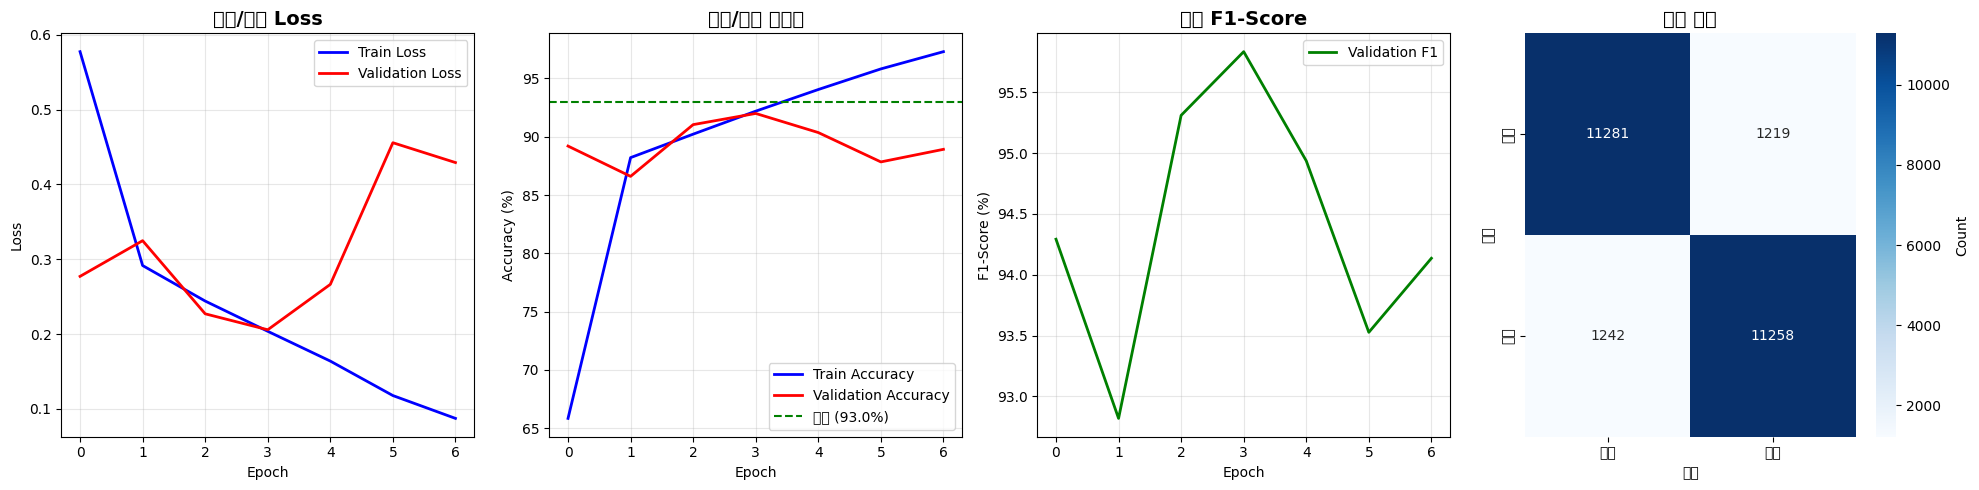

In [24]:
# 상세 분류 리포트
print(f"\n📋 상세 분류 리포트:")
target_names = ['부정', '긍정']
print(classification_report(test_labels, test_predictions, target_names=target_names))

# 학습 곡선 시각화
plt.figure(figsize=(20, 5))

# Loss 곡선
plt.subplot(1, 4, 1)
plt.plot(train_losses, label='Train Loss', color='blue', linewidth=2)
plt.plot(val_losses, label='Validation Loss', color='red', linewidth=2)
plt.title('학습/검증 Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy 곡선
plt.subplot(1, 4, 2)
plt.plot([acc*100 for acc in train_accuracies], label='Train Accuracy', color='blue', linewidth=2)
plt.plot([acc*100 for acc in val_accuracies], label='Validation Accuracy', color='red', linewidth=2)
plt.axhline(y=MODEL_CONFIG['target_accuracy']*100, color='green', linestyle='--', label=f"목표 ({MODEL_CONFIG['target_accuracy']*100:.1f}%)")
plt.title('학습/검증 정확도', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)

# F1-Score 곡선
plt.subplot(1, 4, 3)
plt.plot([f1*100 for f1 in val_f1_scores], label='Validation F1', color='green', linewidth=2)
plt.title('검증 F1-Score', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('F1-Score (%)')
plt.legend()
plt.grid(True, alpha=0.3)

# 혼동 행렬
plt.subplot(1, 4, 4)
cm = confusion_matrix(test_labels, test_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names,
            cbar_kws={'label': 'Count'})
plt.title('혼동 행렬', fontsize=14, fontweight='bold')
plt.xlabel('예측')
plt.ylabel('실제')

plt.tight_layout()
plt.show()

# 실시간 감정 분석 함수
def predict_sentiment(text, model, tokenizer, device, max_length=256):
    model.eval()
    
    # 토큰화
    encoding = tokenizer(
        text,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        logits = model(input_ids, attention_mask)
        probabilities = torch.softmax(logits, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][predicted_class].item()
    
    sentiment = "긍정" if predicted_class == 1 else "부정"
    return sentiment, confidence, probabilities[0].cpu().numpy()

In [25]:
# 감정 분석 테스트
print("\n" + "="*80)
print("🎭 실시간 감정 분석 테스트")
print("="*80)

test_texts = [
    "This movie is absolutely fantastic! I loved every minute of it.",
    "What a terrible waste of time. Boring and pointless.",
    "The plot was okay, but the acting was amazing.",
    "I fell asleep halfway through. Not recommended.",
    "One of the best films I've ever seen. Highly recommended!",
    "The movie was decent, nothing special though.",
    "Brilliant cinematography and outstanding performances.",
    "Completely disappointed. Expected much better."
]

for text in test_texts:
    sentiment, confidence, probs = predict_sentiment(text, model, tokenizer, device)
    print(f"📝 텍스트: '{text}'")
    print(f"🎯 예측: {sentiment} (신뢰도: {confidence:.3f})")
    print(f"📊 확률: 부정 {probs[0]:.3f}, 긍정 {probs[1]:.3f}")
    print("-" * 60)

# 최종 성능 요약
print("\n" + "="*80)
print("📈 최종 성능 요약")
print("="*80)

final_allocated, final_reserved = check_memory()

print(f"🎯 목표 정확도: {MODEL_CONFIG['target_accuracy']*100:.1f}%")
print(f"🏆 달성 정확도: {test_acc*100:.2f}%")
print(f"⏱️  총 훈련 시간: {total_time/60:.1f}분")
print(f"🔧 사용된 에포크: {len(train_losses)}/{MODEL_CONFIG['max_epochs']}")
print(f"💾 GPU 메모리 사용: {final_allocated:.2f}GB")
print(f"🚀 GPU 활용률: {(final_allocated/12)*100:.1f}%")


🎭 실시간 감정 분석 테스트
📝 텍스트: 'This movie is absolutely fantastic! I loved every minute of it.'
🎯 예측: 긍정 (신뢰도: 0.985)
📊 확률: 부정 0.015, 긍정 0.985
------------------------------------------------------------
📝 텍스트: 'What a terrible waste of time. Boring and pointless.'
🎯 예측: 부정 (신뢰도: 0.999)
📊 확률: 부정 0.999, 긍정 0.001
------------------------------------------------------------
📝 텍스트: 'The plot was okay, but the acting was amazing.'
🎯 예측: 긍정 (신뢰도: 0.951)
📊 확률: 부정 0.049, 긍정 0.951
------------------------------------------------------------
📝 텍스트: 'I fell asleep halfway through. Not recommended.'
🎯 예측: 부정 (신뢰도: 0.994)
📊 확률: 부정 0.994, 긍정 0.006
------------------------------------------------------------
📝 텍스트: 'One of the best films I've ever seen. Highly recommended!'
🎯 예측: 긍정 (신뢰도: 0.997)
📊 확률: 부정 0.003, 긍정 0.997
------------------------------------------------------------
📝 텍스트: 'The movie was decent, nothing special though.'
🎯 예측: 부정 (신뢰도: 0.893)
📊 확률: 부정 0.893, 긍정 0.107
--------------------------

In [26]:
# 모델 저장
model_save_path = f"sentiment_bert_final_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'model_config': MODEL_CONFIG,
    'test_accuracy': test_acc,
    'test_f1': test_f1,
    'vocab_size': tokenizer.vocab_size
}, model_save_path)

print(f"💾 모델 저장 완료: {model_save_path}")
print("\n🎉 BERT Fine-tuning 완료! RTX 3060 성능을 최대한 활용했습니다!")

💾 모델 저장 완료: sentiment_bert_final_20250705_094927.pth

🎉 BERT Fine-tuning 완료! RTX 3060 성능을 최대한 활용했습니다!
